Universidad de Chile \\
Facultad de Ciencias Físicas y Matemáticas \\
Departamento de Ingeniería Matemática

MA3711-1 Optimización Matemática, 2023-1.      
Profesor: Jorge Amaya.    
Auxiliar: Aldo Gutierrez.     
Ayudante: Carolina Chiu.    
Alumna: Antonia Valenzuela.    

# Tarea Numérica $\#2$

## Modelo conceptual, hipótesis y contexto

Se desea enviar a costo mínimo, $150$ kg de producto desde el nodo $1$ al nodo $6$. Desgraciadamente no se conoce la forma que usa la empresa de transporte (llamada TRAN) para fijar el costo sobre cada arco.

Se solicita a la empresa que realice una cotización e indique el costo aplicado a cada arco, de acuerdo al flujo propuesto por usted en el esquema. La empresa envía los costos (en USD) según los flujos indicados en cada arco, según la siguiente matriz de adyacencia:

\begin{equation*}
    \big(c_{0}(x_{ij})\big)_{i,j=1,\dots,6} =
    \begin{pmatrix}
        - &800&900&-&-&-\\
        -&-&150&780&500&-\\
        -&-&-&800&800&-\\
        -&-&-&-&500&900\\
        -&-&-&-&-&950\\
        -&-&-&-&-&-
    \end{pmatrix}.
\end{equation*}

Además, se informan las capacidades máximas $(K_{ij})$ en los arcos, a través de la matriz:

\begin{equation*}
    (K_{ij})_{i,j=1,\dots,6} =
    \begin{pmatrix}
        -&60&150&-&-&-\\
        -&-&50&50&50&-\\
        -&-&-&50&80&-\\
        -&-&-&-&60&50\\
        -&-&-&-&-&150\\
        -&-&-&-&-&-
    \end{pmatrix}.
\end{equation*}

En primera instancia, se propone utilizar el método de los *mínimos cuadrados* para descubrir aproximadamente cuál es la función de costos de la empresa, que en la práctica corresponde al esquema de tarifas de TRAN. Se conjetura que el costo sobre cada arco está representado por una función del tipo logístico, dada por:
\begin{equation*}
    c(x_{ij}) = \dfrac{\alpha e^{ax_{ij}}}{\beta e^{ax_{ij}}+1},
\end{equation*}
donde $\alpha,\beta,a\geq0$. Se dispone a aproximar esta función de costo para tener una mejor información adicional para dar una decisión sobre el problema.

A continuación, se importan librerías que serán de utilidad para resolver los problemas de optimización.

In [21]:
pip install lmfit

In [22]:
pip install --upgrade networkx[default]

In [23]:
#paquetes para manipulación numérica y gráficos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#optimización
from lmfit import Parameters, Model, minimize
import networkx as nx

##Parte 1##
En base a lo ya contextualizado, para estimar (ajustar o calibrar) la función desconocida $c(x_{ij})$, el problema de optimización a solucionar es

$$
 \text{(MC)} \quad  \min \sum_{i,j=1,...,6} (c_0(x_{ij}) - c(\alpha, \beta, a, x_{ij}))^{2} \\
 \text{s.a.} \quad \alpha, \beta, a, x_{ij} \geq 0.
$$

que corresponde por definición al problema de mínimos cuadrados.

A continuación escribimos las matrices de costo, flujo y capacidad máxima.
Por conveniencia de formato (sobre todo para graficar), en las matrices de 6x6 nos interesan los valores que sí están determinados, los cuales se pueden reescribir como arreglos de largo 10.

In [24]:
a=5,10,20,25,40,45,50,70,100,110
b=150,500,500,780,800,800,900,800,950,900
X=np.array(a) #arreglo de flujo
C=np.array(b) #arreglo de costos

##Parte 2##
Se resuelve el problema $(MC)$ para obtener el valor de los parámetros $\alpha, \beta$ y $a$ utilizando la librería *lmfit*.

In [25]:
data    = {"X": X, "C": C} #diccionario
data_df = pd.DataFrame(data=data)

In [26]:
def costo(x, alpha, beta, a):
    """
    Inputs: Valor x y parámetros numéricos alpha, beta, a.
    Output: el valor de la funcion de costo evaluada en x, con
    parametros alpha, beta, a.
    Comentario: Se define la funcion de costo en terminos de los
    parametros alpha, beta, a no negativos, presentada en el modelo
    conceptual.
    """
    if np.abs(x) < 1e-3:
        output = 0
    else:
        output = alpha*np.exp(a*x)/(beta*np.exp(a*x)+1)
    return output

def resta(theta, data):

    alpha = theta["alpha"].value
    beta  = theta["beta"].value
    a     = theta["a"].value

    model = np.array([costo(i[0], alpha, beta, a) for i in zip(data["X"])])
    return model - np.array(data["C"])

In [27]:
theta = Parameters()
theta.add('alpha', value = 1, min=0)
theta.add('beta', value = 1, min=0)
theta.add('a', value =1, min=0)

# Aplicar el metodo de minimizacion
report = minimize(fcn = resta, params = theta,
                  method = "least_squares",  args=[data_df])
alpha, beta, a = report.x

y los valores estimados para $\alpha,\beta, a\geq 0$ se resumen en la tabla a continuación

In [28]:
# Mostrar los resultados
pd.DataFrame(data = {"alpha": [alpha], "beta": [beta], "a": [a]}, index=["Valor estimado"])

,alpha,beta,a
Valor estimado,199.584574,0.228384,0.114552


Adicionalmente, se puede comparar la curva estimada fijando los valores para $\alpha, \beta$ y $a$, con los costos dados por la empresa.

In [29]:
#fijamos los valores encontrados para graficar
alpha=report.params.valuesdict()['alpha']
beta=report.params.valuesdict()['beta']
a=report.params.valuesdict()['a']

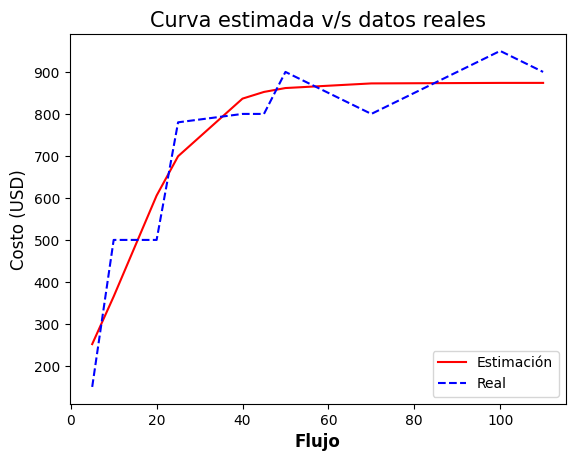

In [30]:
plt.figure()
plt.title("Curva estimada v/s datos reales", fontsize = 15)
plt.xlabel("Flujo", fontdict = {'fontsize':12, 'fontweight':'bold'})
plt.ylabel("Costo (USD)", fontsize = 12)
plt.plot(X,np.array([costo(i[0], alpha, beta, a) for i in zip(data["X"])]),'r-',label='Estimación')
plt.plot(X, C,'b--', label='Real') #real
plt.legend(loc = "lower right")
plt.show()

Y  el costo total dado por la función recién calculada según la propuesta de flujo hecha se calcula como sigue

In [31]:
#X es el flujo propuesto en el dígrafo
def costototal(X,alpha,beta,a):
    output=0
    for i in X:
       output= output + costo(i,alpha,beta,a) #como la función costos en su primera variable recibe números, indexamos en i los elementos de X

    return output

print(costototal(X,alpha,beta,a))

7092.783400533572


De este modo, con la estimación nos resulta un costo de 7092 USD. Por otro lado, el costo total según los valores proporcionados por la empresa corresponde a 7080 USD. Es claro que ambos valores son cercanos entre sí, en particular, y en consonancia con el gráfico, la aproximación entrega un costo levemente mayor al real. Teniendo esto en cuenta junto con el gráfico, se tiene certeza de que se ejecutó una estimación apropiada.

In [32]:
"""
la matriz de costos incluye los costos dados según el flujo propuesto, por lo que para contar el costo total
nos limitamos a contar las cantidades del array.
"""
output=0
for i in C:
      output= output + i

print(output)

7080


##Parte 3
Dado que ya estimamos los valores de los parámetros $\alpha, \beta$ y $a$, tenemos nuestra función de costos y nos proponemos resolver el siguiente problema no lineal de transporte

$$
\begin{align}
\text{(P)}\quad \min &\sum_{j=1}^{6}\sum_{i=1}^{6} c(x_{ij}) \\
\text{s.a.}  \quad  &x_{1,2}+x_{1,3} = 150 \\
& x_{4,6}+ x_{5,6}=150 \\
& \sum_{i=1}^{n} x_{ij} = \sum_{l=1}^{m} x_{jl} \quad \forall i,j,l \in \mathcal{A}\\
& 0 \leq x_{ij} \leq k_{ij} \quad \forall i,j \in \mathcal{A}.
\end{align}
$$

Donde buscamos un flujo óptimo a costo mínimo para enviar los 150 kg de producto entre los nodos de origen y destino. \\


La función objetivo corresponde a una sumatoria doble o, equivalentemente, se puede escribir como una sumatoria única indexada sobre el par ordenado $(i,j)$ de la función de costos evaluada en el flujo, donde éste último corresponde a la(s) variable(s) de decisión.


La primera restricción establece que el flujo saliente del nodo de origen (que corresponde a la oferta) es en total 150, mientras que la segunda restricción señala que el flujo de llegada al nodo destino es igualmente 150 (corresponde a la demanda). \\

La tercera restricción es sobre los nodos de transporte, e indica que el flujo entrante a un nodo debe ser igual al que parte desde éste. El índice $j$ indexa el nodo de transporte en sí (por tanto se considera sólo entre 2 y 5), mientras $i$ se mueve $1,...,n$, donde n representa la cantidad de arcos entrando al nodo, y $l$, análogamente, va contando desde 1 hasta $m$, donde éste último representa la cantidad de arcos alejándose del nodo. \\

El conjunto $\mathcal{A} \subseteq \{1,2,3,4,5,6\}^{2}$ representa los arcos que en efecto se consideran para transportar los flujos entre los nodos. Es decir, se considerarán aquellos arcos que sí tengan un costo y capacidades máximas asociadas. Esta condición además excluye los pares ordenados $(i,j)$ tales que $i = j$, pues es redundante definir arcos sobre un mismo nodo. Otro ejemplo de esto es que el índice $j$ nunca tomará los valores 1 y 6 pues esto implicaría que existen arcos que llegan al nodo 1, o bien que salen del nodo 6, siendo éstos los nodos de origen y destino respectivamente (notemos que la columna 1 y la fila 6 presentadas en la contextualización carecen de valores). \\

Luego, $k_{ij}$ representa los términos de la matriz de capacidades.

##Parte 4
Se resuelve el problema $(P)$ planteado anteriormente mediante el solver Gekko, y a partir de la solución encontrada se puede dibujar un grafo que expone la nueva propuesta de flujos para el problema de transporte.

In [33]:
pip install --upgrade gekko

In [34]:
import networkx as nx
import numbers
def draw_graph(Flujo_y_mas, is_dict = False, shape = 0):
    arcos = []
    G = nx.DiGraph()
    if shape == 0:
        m = Flujo_y_mas.shape[0]
    else:
        m = shape
    for i in range(m):
        for j in range(m):
            #if isinstance(Flujo_y_mas[0][0], numbers.Number):
            if not is_dict:
                if Flujo_y_mas[i,j] > 0:
                    arcos.append((i,j))
            else:
                if Flujo_y_mas[i,j].value[0] > 0:
                    arcos.append((i,j))
    if not is_dict:
        for k in range(len(arcos)):
            (i,j)=arcos[k]
            G.add_edge(arcos[k][0], arcos[k][1], weight=Flujo_y_mas[i,j])
    else:
        for k in range(len(arcos)):
            (i,j)=arcos[k]
            G.add_edge(arcos[k][0], arcos[k][1], weight=Flujo_y_mas[i,j].value[0])

    #Hecho para maximo 6 nodos en default
    pos = {0: (0, 0), 1: (10, 5), 2: (10, -5), 3: (30, 5), 4: (30, -5), 5: (40, 0)}

    #nodes
    nx.draw_networkx(G, pos, node_size=700)

    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels,font_size=12, font_family="sans-serif",
                                label_pos = 0.33, rotate =False)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [35]:
#los flujos deben ser positivos.
COTA_INF = np.zeros((6,6))
COTA_INF[0] = np.array([0,0,0,0,0,0])
COTA_INF[1] = np.array([0,0,0,0,0,0])
COTA_INF[2] = np.array([0,0,0,0,0,0])
COTA_INF[3] = np.array([0,0,0,0,0,0])
COTA_INF[4] = np.array([0,0,0,0,0,0])
COTA_INF[5] = np.array([0,0,0,0,0,0])

#imponemos las capacidades máximas de flujo que soporta cada arco.
COTA_SUP = np.zeros((6,6))
COTA_SUP[0] = np.array([0,60,150,0,0,0])
COTA_SUP[1] = np.array([0,0,50,50,50,0])
COTA_SUP[2] = np.array([0,0,0,50,80,0])
COTA_SUP[3] = np.array([0,0,0,0,60,50])
COTA_SUP[4] = np.array([0,0,0,0,0,150])
COTA_SUP[5] = np.array([0,0,0,0,0,0])

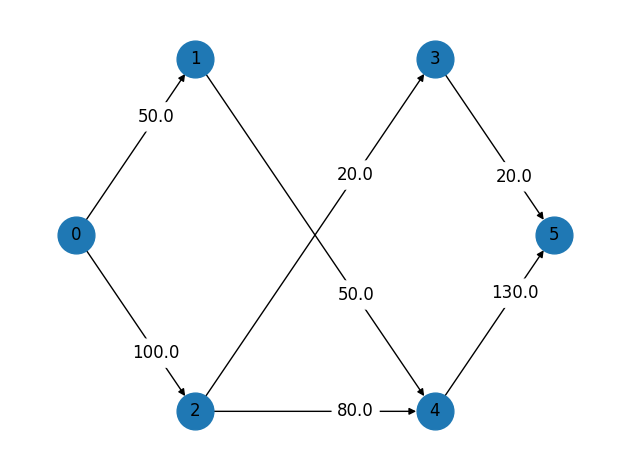

In [36]:
from gekko import GEKKO

#creamos una indicatriz con el fin de considerar sólo los arcos que en efecto transportan flujo
# i.e aquellos que tienen asociado un costo no nulo.
m = GEKKO()
m.options.SOLVER=1
variables = {}
indicatriz = {}
for i in range(6): #Son 6 nodos
    for j in range(6): #Creamos x_{ij}
        variables[i,j] = m.Var(value=0, lb= COTA_INF[i][j], ub=COTA_SUP[i][j], integer=False)
        indicatriz[i,j]=m.if3(-variables[i,j],1,0)

# Creamos las restricciones
m.Equation(variables[0,1]+variables[0,2]==150)
m.Equation(variables[3,5]+variables[4,5]==variables[0,1]+variables[0,2])
m.Equation(variables[0,1]==(variables[1,2]+variables[1,3]+variables[1,4])) #nodo 2
m.Equation((variables[0,2]+variables[1,2])==(variables[2,3]+variables[2,4])) #nodo 3
m.Equation((variables[1,3]+variables[2,3])==(variables[3,4]+variables[3,5])) #nodo 4
m.Equation((variables[1,4]+variables[2,4]+variables[3,4]==variables[4,5]))  #nodo 5

#No hay flujo en el mismo nodo
for i in range(6):
    m.Equation(variables[i,i] == 0)

#m.Obj(m.sum(f_obj(variables)))
m.Obj((m.sum([((alpha*m.exp(a*variables[i,j]))/(beta*m.exp(a*variables[i,j])+1))*indicatriz[i,j] for i in range(6) for j in range(6)])))
m.solve(disp=False) # Solve
draw_graph(variables, is_dict = True, shape = 6)

Se verifica que el grafo resultante respeta las capacidades máximas de cada arco. Luego, el nuevo flujo propuesto es mucho más óptimo respecto al propuesto inicialmente, pues al calcular el costo total que produce enviar 150 kg de producto desde el nodo 1 al nodo 6, éste resulta ser de aproximadamente 5555,76 USD, valor evidentemente menor a los presentados en la sección precedente.

In [37]:

m.options.objfcnval

5555.7671876

##Parte 5
Ahora la empresa TRAN carga un costo adicional por el simple hecho de usar un arco. La siguiente matriz resume el cargo

$$
[\lambda_{ij}]=
\begin{pmatrix}
- & 100 & 40 & - & - & - \\
- & - & 45 & 45 & 45 & - \\
- & - & - & 10 & 10 & - \\
- & - & - & - & 30 & 10 \\
- & - & - & - & - & 10  \\
- & - & - & - & - & -
\end{pmatrix}
$$

Escribamos el nuevo modelo considerando los costos agregados, el cual es completamente símil al anterior $(P)$
$$
\begin{align}
\text{(P')} \quad \min &\sum_{j=1}^{6}\sum_{i=1}^{6} (c(x_{ij})+ \lambda_{ij} ) \\
 \text{s.a.}  \quad & x_{1,2}+x_{1,3} = 150 \\
& x_{4,6}+ x_{5,6}=150 \\
& \sum_{i=1}^{n} x_{ij} = \sum_{l=1}^{m} x_{jk} \quad \forall i,j,l \in \mathcal{A}\\
& x_{ij} \in [0,k_{ij}] \quad \forall i,j \in \mathcal{A}.
\end{align}
$$


##Parte 6
Se determina la solución del modelo $(P')$, cuyo procedimiento es análogo al ejecutado para resolver $(P)$.

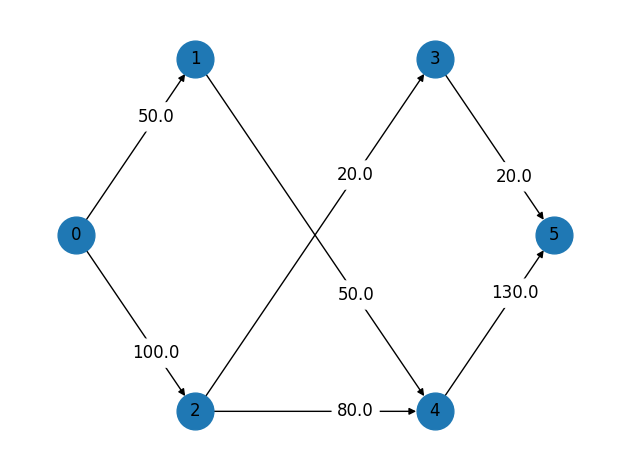

In [38]:
#Primero escribimos la matriz de costos adicionales
Lambda = np.zeros((6,6))
Lambda[0] = np.array([0,100,40,0,0,0])
Lambda[1] = np.array([0,0,45,45,45,0])
Lambda[2] = np.array([0,0,0,10,10,0])
Lambda[3] = np.array([0,0,0,0,30,10])
Lambda[4] = np.array([0,0,0,0,0,10])
Lambda[5] = np.array([0,0,0,0,0,0])

m = GEKKO()
m.options.SOLVER=1
variables = {}
#pues nuestra función a optimizar involucra la función indicatriz
indicatriz = {}
for i in range(6): #Son 6 nodos
    for j in range(6): #Creamos x_{ij}
        variables[i,j] = m.Var(value=0, lb= COTA_INF[i][j], ub=COTA_SUP[i][j], integer=False)
        indicatriz[i,j]=m.if3(-variables[i,j],1,0)

# Creamos las restricciones
m.Equation(variables[0,1]+variables[0,2]==150)
m.Equation(variables[3,5]+variables[4,5]==variables[0,1]+variables[0,2])
m.Equation(variables[0,1]==(variables[1,2]+variables[1,3]+variables[1,4])) #nodo 2
m.Equation((variables[0,2]+variables[1,2])==(variables[2,3]+variables[2,4])) #nodo 3
m.Equation((variables[1,3]+variables[2,3])==(variables[3,4]+variables[3,5])) #nodo 4
m.Equation((variables[1,4]+variables[2,4]+variables[3,4]==variables[4,5])) #nodo 5

#No hay flujo al mismo nodo
for i in range(6):
    m.Equation(variables[i,i] == 0)

#m.Obj(m.sum(f_obj(variables)))
m.Obj((m.sum([((alpha*m.exp(a*variables[i,j]))/(beta*m.exp(a*variables[i,j])+1)+Lambda[i,j])*indicatriz[i,j] for i in range(6) for j in range(6)])))
m.solve(disp=False) # Solve
draw_graph(variables, is_dict = True, shape = 6)

Resultándonos la misma propuesta de flujo que la dada para $(P)$. Este resultado es consistente al considerar que en el fondo se resuelve un problema de optimización casi idéntico (mismas cotas y restricciones), con diferencias no mayores en la nueva función objetivo que son, básicamente, constantes. \\

Naturalmente, al aplicarse un cargo adicional, el costo total dado será superior que el dado para $(P)$, correspondiendo a aproximadamente 5780,76 USD. Es directo notar que, incluso considerando el nuevo cargo fijo, el costo entregado en el óptimo sigue siendo menor al costo total real dado por la propuesta de flujo inicial (el cual está desprovisto del costo adicional), y se puede reafirmar que encontramos una propuesta óptima.

In [39]:

m.options.objfcnval

5780.7671876